# Getting started with pycea



In [156]:
import pycea as py
import scanpy as sc

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## TreeData object

Pycea is built to work with the {class}`treedata.TreeData`, a wrapper around {class}`anndata.AnnData` which adds two additional attributes, `obst` and `vart`, to store trees for observations and variables. To learn more about `TreeData` take a look at the [getting started guide](https://treedata.readthedocs.io/en/latest/notebooks/getting-started.html).

For this tutorial, we will use a `TreeData` containing a single tumor from the KP mouse lineage tracing dataset published by [Yang, Jones, et al. 2022](https://doi.org/10.1016/j.cell.2022.04.015).

In [ ]:
tdata = py.datasets.yang22()
tdata

TreeData object with n_obs × n_vars = 1109 × 2000
    obs: 'tumor', 'mouse', 'lane', 'fitness', 'plasticity', 'cluster', 'tree'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'priors'
    obsm: 'X_scVI', 'X_umap', 'characters'
    layers: 'counts'
    obst: '3435_NT_T1'

Here `obst` contains a single lineage tree named `3435_NT_T1`, which is represented as a {class}`nx.DiGraph`.

In [209]:
print(tdata.obst["3435_NT_T1"])

DiGraph with 1890 nodes and 1889 edges


## Plotting basics

Pycea implements an intuitive plotting language where complex plots can be built from simple components. The first step is to render the branches using {func}`pycea.pl.branches`.

<Axes: >

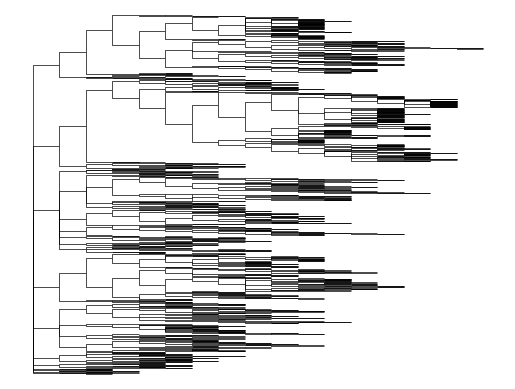

In [215]:
py.pl.branches(tdata)

{func}`pycea.pl.annotations` adds leaf annotations to a plot, such as the indels used to reconstruct the lineage tree which are stored in `tdata.obsm["characters"]`. Here we use {func}`pycea.get.palette` to generate an indel color palette and specify that branches should be extended.

<Axes: >

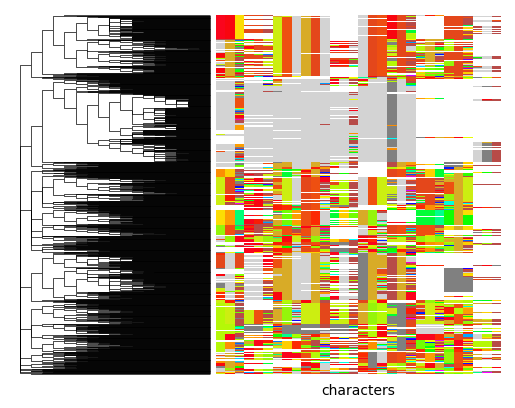

In [281]:
indel_palette = py.get.palette(
    tdata, "characters", custom={"-": "white", "*": "lightgrey"}, cmap="gist_rainbow", priors=tdata.uns["priors"]
)
py.pl.branches(tdata, extend_branches=True)
py.pl.annotation(tdata, keys="characters", palette=indel_palette)

{func}`pycea.pl.nodes` renders node data on a plot. For example, we can render a polar tree with internal nodes colored by their depth and leaves annotated with their estimated phylogenetic fitness from [Yang, Jones, et al. 2022](https://doi.org/10.1016/j.cell.2022.04.015).

<PolarAxes: >

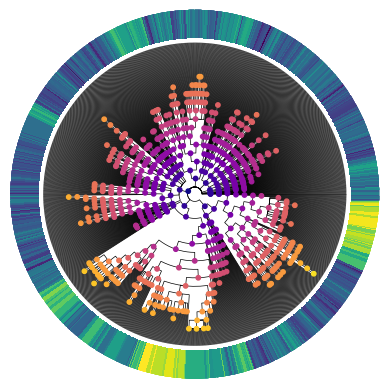

In [ ]:
py.pl.branches(tdata, extend_branches=True, polar=True)
py.pl.annotation(tdata, keys="fitness", cmap="viridis", width=0.2)
py.pl.nodes(tdata, color="depth", cmap="plasma")

For convenience, Pycea also implements {func}`pycea.pl.tree` which combines the above functions. {func}`pycea.pl.tree` is useful for quickly visualizing a tree, but does not provide the same flexibility as plotting components individually.

<PolarAxes: >

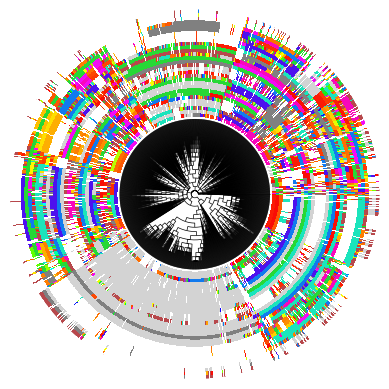

In [ ]:
py.pl.tree(tdata, keys="characters", polar=True, extend_branches=True, palette=indel_palette)

## Scanpy integration

Since {class}`treedata.TreeData` is a wrapper around {class}`anndata.AnnData`, it is fully compatible with the [scverse](https://scverse.org/) ecosystem and can be used wherever {class}`anndata.AnnData` is used. For example, we can use [scanpy](https://scanpy.readthedocs.io/en/stable/) to generate a UMAP embedding of the tumor cell's transcriptional state.

/lab/solexa_weissman/wcolgan/tools/miniconda3/envs/pycea/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


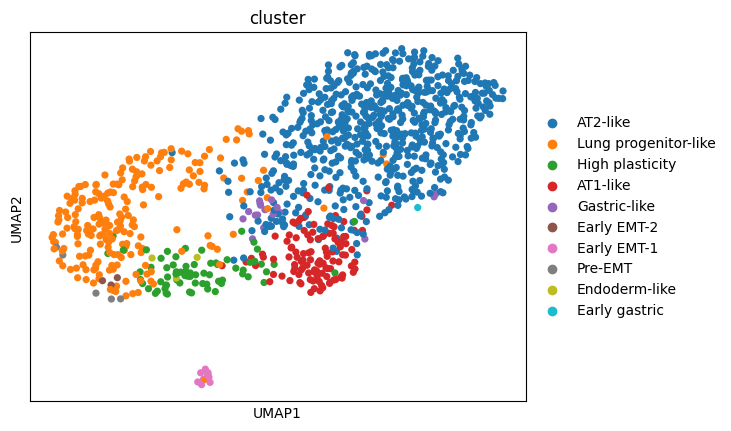

In [240]:
sc.tl.pca(tdata)
sc.pp.neighbors(tdata)
sc.tl.umap(tdata, random_state=42)
sc.pl.umap(tdata, color="cluster")

In [262]:
sc.tl.leiden(tdata, resolution=0.7, flavor="igraph")

In [263]:
del tdata.uns["leiden_colors"]

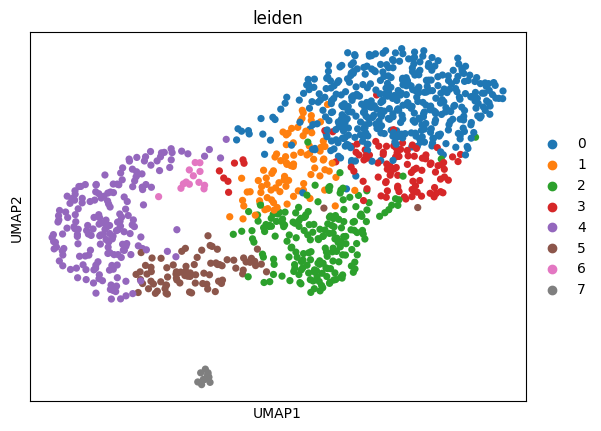

In [264]:
sc.pl.umap(tdata, color="leiden")

<PolarAxes: >

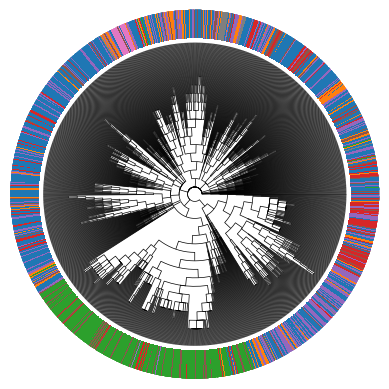

In [265]:
py.pl.tree(tdata, keys=["leiden"], polar=True, extend_branches=True, annotation_width=0.2)